# Import modules

In [86]:
import glob
import os.path
import numpy as np
import mne
import matplotlib.pyplot as plt
import yasa

plt.style.use('default')
plt.rc('font', family='Arial')
plt.rc('axes', unicode_minus=False)

mne.set_log_level('CRITICAL')

# Import data and check visually

In [87]:
path_data = r'C:\Users\HP\PycharmProjects\as_monkey_eeg\X8_data'

files = glob.glob(os.path.join(path_data, '**', 'raw.edf'), recursive=True)
print(*files, sep='\n')

C:\Users\HP\PycharmProjects\as_monkey_eeg\X8_data\24_03_08\0637\raw.edf
C:\Users\HP\PycharmProjects\as_monkey_eeg\X8_data\24_03_08\0800\raw.edf
C:\Users\HP\PycharmProjects\as_monkey_eeg\X8_data\24_03_09\0629\raw.edf
C:\Users\HP\PycharmProjects\as_monkey_eeg\X8_data\24_03_09\0633\raw.edf


> [How to operate files and paths](https://zhuanlan.zhihu.com/p/600048459)

File 1 as example. Get the file and animal name

In [88]:
file = files[0]
session, animal = np.array(file.split('\\'))[[-3, -2]]

In [89]:
raw = mne.io.read_raw_edf(file, preload=True, verbose=False)

t = raw.times
sf = raw.info['sfreq']
print(raw.ch_names)

['EEG', 'Loco']


In [90]:
raw.set_channel_types({'Loco': 'bio'})
_ = raw.notch_filter(np.arange(50, 250, 50))


D:\Softwares\anaconda3\envs\rsa32_in_monkeys\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


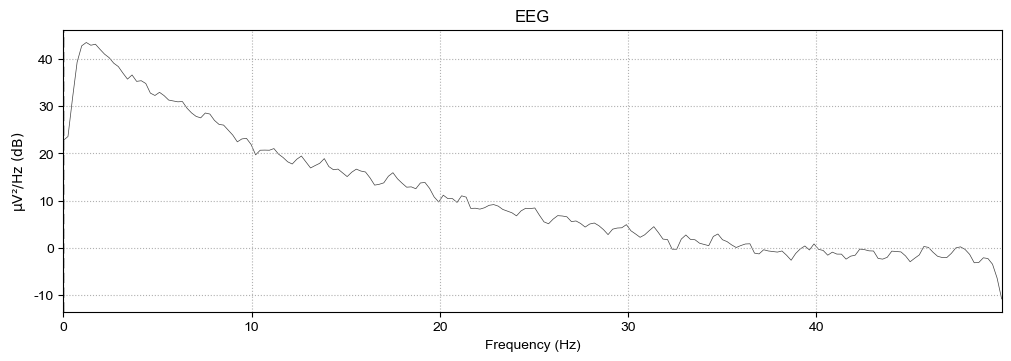

In [91]:
raw.compute_psd(fmax=50).plot()
plt.show()

Power in low frequency band was very high, which may caused by eye blink or others. 

# Preprocessing

## Ocular actifacts detection

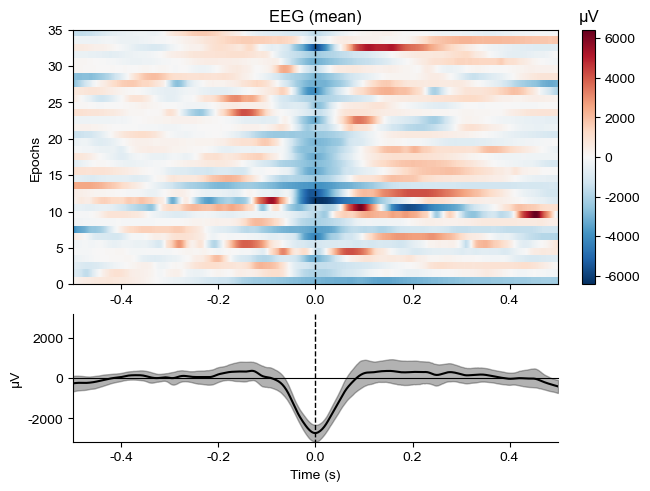

[<Figure size 640x480 with 3 Axes>]

In [92]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw.copy().filter(1, 40), ch_name='EEG', baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine="mean")

> [Overview of artifact detection -> Artifact detection -> Ocular artifacts (EOG)](https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py)

In [93]:
eog_events = mne.preprocessing.find_eog_events(raw, ch_name='EEG')
onsets = eog_events[:, 0] / raw.info["sfreq"] - 0.25
durations = [0.5] * len(eog_events)
descriptions = ["bad blink"] * len(eog_events)
annot_blink = mne.Annotations(
    onsets, durations, descriptions, orig_time=raw.info["meas_date"]
)


> [Rejecting bad data spans and breaks -> Annotating bad spans of data -> Generating annotations programmatically](https://mne.tools/stable/auto_tutorials/preprocessing/20_rejecting_bad_data.html)

## Muscle activity detection

In [94]:
thr = 1.5
annot_muscle, scores_muscle = mne.preprocessing.annotate_muscle_zscore(
    raw,
    ch_type='eeg',
    threshold=thr,
    min_length_good=0.5,
    filter_freq=[110, 120],
)

> [Annotate muscle artifacts](https://mne.tools/stable/auto_examples/preprocessing/muscle_detection.html)

## Overview the signals and artifacts

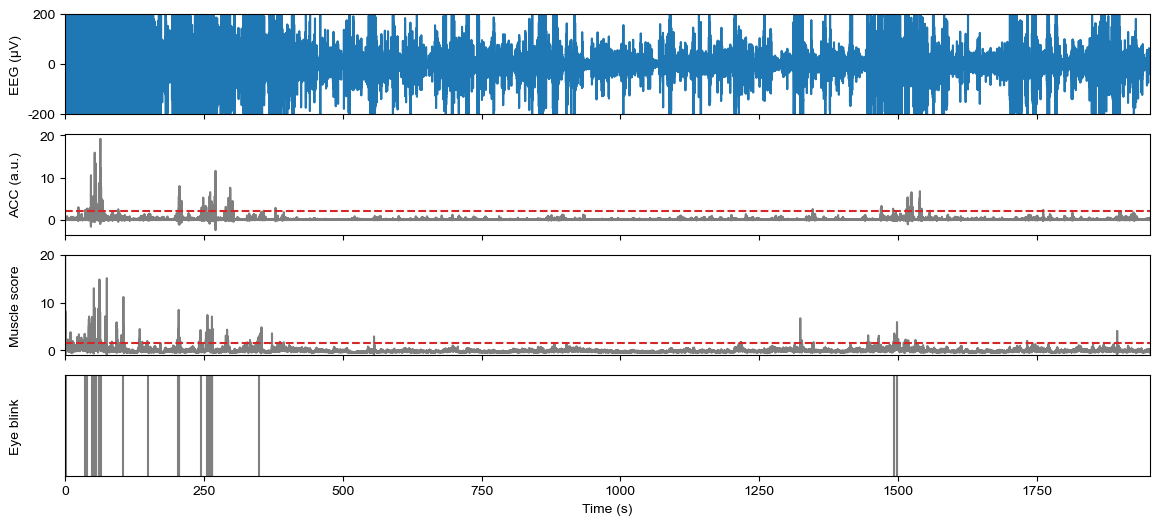

In [95]:
fig, ax_list = plt.subplots(4, 1, figsize=(14, 6), sharex='all')
ax_list[0].plot(t, raw.copy().pick([0]).filter(1, 40).get_data(units='uV').squeeze())
ax_list[0].set(
    ylabel='EEG (μV)',
    ylim=(-200, 200),
    xlim=(t[[0, -1]])
)

ax_list[1].plot(t, raw.copy().pick([1]).get_data().squeeze(), color='tab:gray')
ax_list[1].hlines(2, *t[[0, -1]], colors='tab:red', linestyles='--')
ax_list[1].set(
    ylabel='ACC (a.u.)',
    # ylim=(-200, 200), 
    xlim=(t[[0, -1]])
)

ax_list[2].plot(t, scores_muscle, color='tab:gray')
ax_list[2].hlines(thr, *t[[0, -1]], colors='tab:red', linestyles='--')
ax_list[2].set(
    ylabel='Muscle score',
    ylim=(-1, 20),
    xlim=(t[[0, -1]])
)
ax_list[3].vlines(onsets, ymin=-1, ymax=1, colors='tab:gray')
ax_list[3].set(
    ylim=(0, 1),
    ylabel='Eye blink',
    xlim=(t[[0, -1]]),
    yticks=[]
)
ax_list[-1].set_xlabel('Time (s)')
fig.align_labels()
plt.show()

## Drop bad

In [96]:
_ = raw.set_annotations(raw.annotations + annot_blink + annot_muscle)

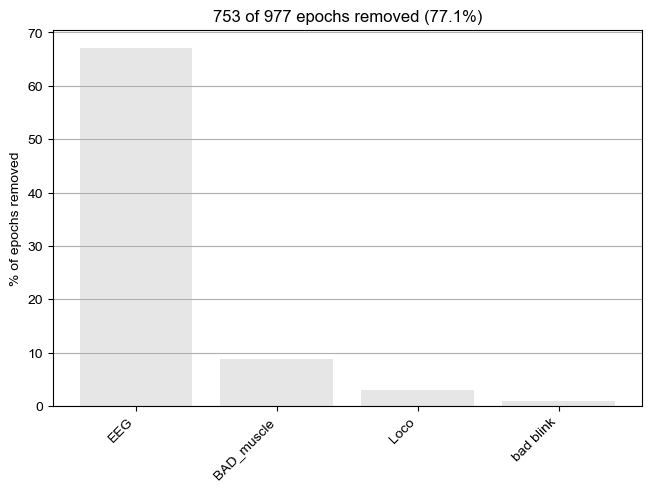

In [97]:
epochs = mne.make_fixed_length_epochs(raw.copy().filter(1, 40), duration=2, preload=True)
epochs.drop_bad(flat=dict(eeg=5e-6), reject={'bio': 2, 'eeg': 100e-6})

epochs.plot_drop_log()
plt.show()

## Replot the cleaned signals

In [98]:
raw_clean = raw.copy()
raw_clean.filter(1, 40)
data = raw_clean.get_data()

data = data.reshape(2, len(epochs.drop_log), -1)

flag = np.ones(len(epochs.drop_log), dtype='bool')
flag[epochs.selection] = False
data[0, flag, :] = np.nan
data = data.reshape(2, -1)

raw_clean._data = data

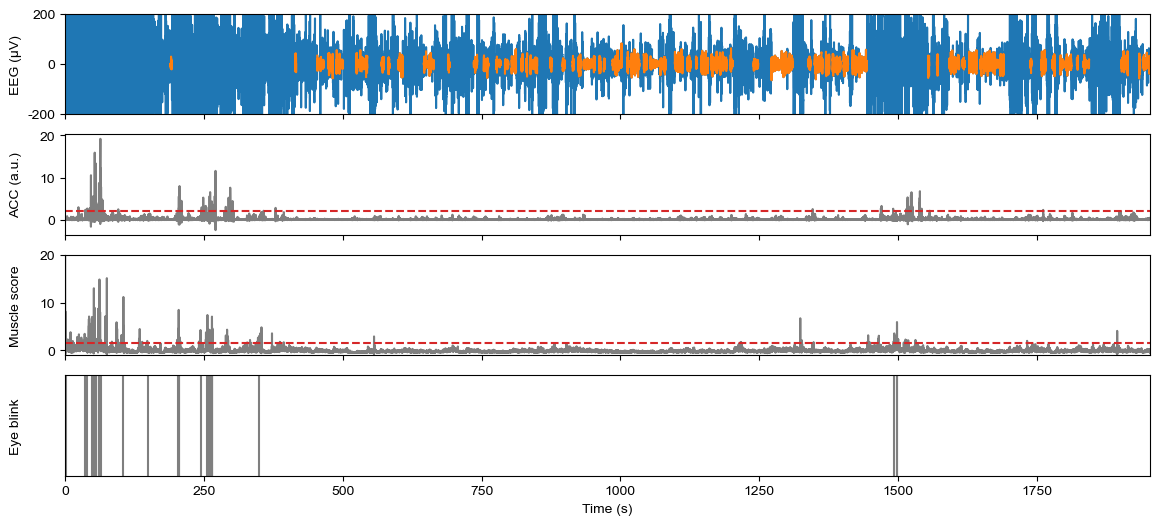

In [99]:
fig, ax_list = plt.subplots(4, 1, figsize=(14, 6), sharex='all')
ax_list[0].plot(t, raw.copy().filter(1, 40).pick([0]).get_data(units='uV').squeeze())
ax_list[0].plot(t, raw_clean.copy().pick([0]).get_data(units='uV').squeeze())
ax_list[0].set(
    ylabel='EEG (μV)',
    ylim=(-200, 200),
    xlim=(t[[0, -1]])
)

ax_list[1].plot(t, raw.copy().pick([1]).get_data().squeeze(), color='tab:gray')
ax_list[1].hlines(2, *t[[0, -1]], colors='tab:red', linestyles='--')
ax_list[1].set(
    ylabel='ACC (a.u.)',
    # ylim=(-200, 200), 
    xlim=(t[[0, -1]])
)

ax_list[2].plot(t, scores_muscle, color='tab:gray')
ax_list[2].hlines(thr, *t[[0, -1]], colors='tab:red', linestyles='--')
ax_list[2].set(
    ylabel='Muscle score',
    ylim=(-1, 20),
    xlim=(t[[0, -1]])
)
ax_list[3].vlines(onsets, ymin=-1, ymax=1, colors='tab:gray')
ax_list[3].set(
    ylim=(0, 1),
    ylabel='Eye blink',
    xlim=(t[[0, -1]]),
    yticks=[]
)
ax_list[-1].set_xlabel('Time (s)')
fig.align_labels()
plt.show()

# Frequency domain analysis

In [149]:
eeg = data[0]* 1e6
flag_nan = np.isnan(eeg)
eeg_cleaned = np.delete(eeg, flag_nan)

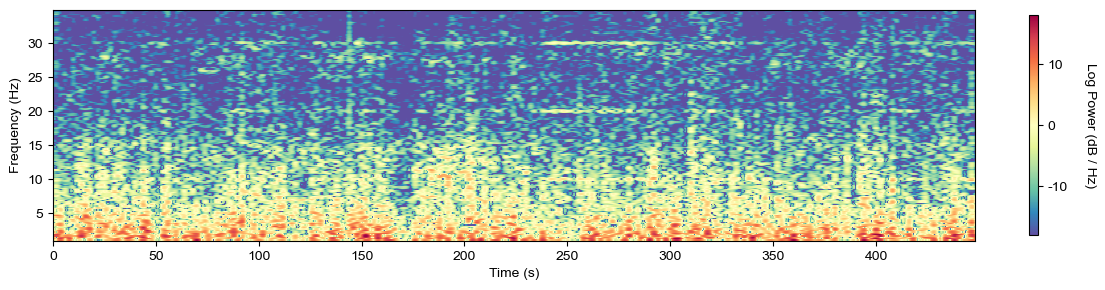

In [147]:
f, t, Sxx = yasa.stft_power(eeg_cleaned, sf, window=5, step=2, band=(1, 35))
Sxx_db = 10* np.log10(np.abs(Sxx))
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
im = ax.pcolormesh(t, f, Sxx_db, cmap='Spectral_r', vmin=-18, vmax=18)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

cbar = fig.colorbar(im, ax=ax, shrink=0.95, fraction=0.1, aspect=25)
cbar.ax.set_ylabel("Log Power (dB / Hz)", rotation=270, labelpad=20)
plt.show()

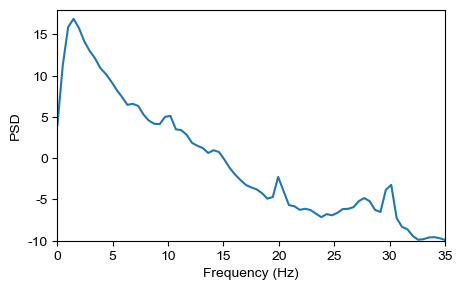

In [144]:
from scipy import signal

plt.figure(figsize=(5, 3))
f, Pxx_den = signal.welch(eeg_cleaned, sf, nperseg=1024)
Pxx_den_db = 10 * np.log10(Pxx_den)
plt.plot(f, Pxx_den_db)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xlim(0, 35)
plt.ylim(-10, 18)
plt.show()

In [155]:
bands=[
    (0.5, 4, "Delta"),
    (4, 8, "Theta"),
    (8, 12, "Alpha"),
    (12, 30, "Beta"),
]
df = yasa.bandpower(eeg_cleaned, sf, bands=bands)
df

,Delta,Theta,Alpha,Beta,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,
CHAN000,0.66225,0.175208,0.065486,0.066059,117.910814,0.25,True
